In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import cv2 as cv
import numpy as np
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split


def load_data(path, split=0.1):
     images = sorted(glob(os.path.join(path, "images/*")))
     masks = sorted(glob(os.path.join(path, "masks/*")))

     #80-train
     #10-vaidation
     #10-testing 
     total_size = len(images)
     valid_size = int(split * total_size)
     test_size = int(split * total_size)

     train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
     train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

     train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
     train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

     return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)


def read_image(path):
    path = path.decode()
    x = cv.imread(path, cv.IMREAD_COLOR)
    x = cv.resize(x, (256, 256))
    x = x / 255.0
    return x


def read_mask(path):
    path = path.decode()
    x = cv.imread(path, cv.IMREAD_GRAYSCALE)
    x = cv.resize(x, (256, 256))
    x = x / 255.0
    ##(256,256)
    x = np.expand_dims(x, axis=-1)
    ##(256,256,1)
    return x


def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([256, 256, 3])
    y.set_shape([256, 256, 1])
    return x, y


def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset


if __name__ == "__main__":
    print("")
    path = "/content/drive/MyDrive/Polyp_dataset/Kvasir-SEG"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
    print(len(train_x), len(valid_x), len(test_x))

    ds = tf_dataset(test_x, test_y)
    for x, y in ds:
        print(x.shape, y.shape)
        break




800 100 100
(8, 256, 256, 3) (8, 256, 256, 1)


In [ ]:


import keras

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def build_model():
    size = 256
    num_filters = [16, 32, 48, 64]
    inputs = keras.Input((size, size, 3))

    skip_x = []
    x = inputs
    ## Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)

    ## Bridge
    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()
    ## Decoder
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = conv_block(x, f)

    ## Output
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    return Model(inputs, x)


if __name__ == "__main__":
    model = build_model()
    model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
import keras.backend as K
epsilon = 1e-5
smooth = 1


In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

if __name__ == "__main__":
    ## Dataset
    path = "/content/drive/MyDrive/Polyp_dataset/Kvasir-SEG"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)

    ## Hyperparameters
    batch = 8
    lr = 1e-4
    epochs = 10

    train_dataset = tf_dataset(train_x, train_y, batch=batch)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

    model1 = build_model()

    opt = tf.keras.optimizers.Adam(lr)
    metrics1 = ["acc", tf.keras.metrics.Recall(), tf.keras.metrics.Precision(),dsc]
    model1.compile(loss=bce_dice_loss, optimizer=opt, metrics=metrics1)

    callbacks = [
        ModelCheckpoint("files/model1.h5"),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
        CSVLogger("files/data3.csv"),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
    ]

    train_steps = len(train_x)//batch
    valid_steps = len(valid_x)//batch

    if len(train_x) % batch != 0:
        train_steps += 1
    if len(valid_x) % batch != 0:
        valid_steps += 1


    history1=model1.fit(train_dataset,
        validation_data=valid_dataset,
        epochs=epochs,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks)


Epoch 1/10
 88/100 [=========================>....] - ETA: 2s - loss: 1.3892 - acc: 0.5726 - recall_3: 0.8226 - precision_3: 0.2487 - dsc: 0.2839

UnknownError: ignored

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np
 

In [ ]:
plt.plot(history1.history["loss"])
plt.plot(history1.history["val_loss"])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper right')
plt.show

NameError: ignored

In [ ]:
path = "/content/drive/MyDrive/Kvasir-SEG"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)

model1.evaluate(test_x,test_y,batch_size=128)

ValueError: ignored

In [ ]:
history.history

{'acc': [0.7454346418380737,
  0.8560610413551331,
  0.8758367300033569,
  0.8872288465499878,
  0.8969695568084717,
  0.9068336486816406,
  0.9169170260429382,
  0.9270110130310059,
  0.9351626038551331,
  0.9399160742759705,
  0.942584753036499,
  0.9419800043106079,
  0.9466975331306458,
  0.9486202001571655,
  0.950127124786377,
  0.9518224596977234,
  0.9506894946098328,
  0.9517030119895935,
  0.9511958956718445,
  0.9574565291404724],
 'dice_loss': [0.7496080994606018,
  0.7434496283531189,
  0.739605724811554,
  0.7363229393959045,
  0.732940137386322,
  0.7290606498718262,
  0.7252480387687683,
  0.7215595841407776,
  0.7182312607765198,
  0.7157221436500549,
  0.7139248847961426,
  0.7133355140686035,
  0.7112073302268982,
  0.709999144077301,
  0.7086626291275024,
  0.7075153589248657,
  0.7073756456375122,
  0.706551194190979,
  0.7062386274337769,
  0.7039372324943542],
 'loss': [0.5409618616104126,
  0.42115533351898193,
  0.38016390800476074,
  0.3543704152107239,
  0.33

In [ ]:
history1.history

NameError: ignored

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from tqdm import tqdm
#from data import load_data, tf_dataset
#from train import iou

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = np.expand_dims(x, axis=-1)
    return x

def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

if __name__ == "__main__":
    ## Dataset
    path = "/content/drive/MyDrive/Kvasir-SEG"
    batch_size = 8
    (train_x, train_y), (valid_x, valid_y),(test_x,test_y)= load_data(path)

    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)
    test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

    test_steps = (len(valid_x)//batch_size)
    if len(valid_x) % batch_size != 0:
        test_steps += 1

    with CustomObjectScope({'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("files/model.h5")

        model.evaluate(test_dataset,steps=test_steps)

    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        x = read_image(x)
        y = read_mask(y)
        y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
        h, w, _ = x.shape
        white_line = np.ones((h, 10, 3)) * 255.0

        all_images = [
            x * 255.0, white_line,
            mask_parse(y), white_line,
            mask_parse(y_pred) * 255.0
        ]
        image = np.concatenate(all_images, axis=1)
        cv2.imwrite(f"/content/drive/MyDrive/Kvasir-SEG/results/{i}.jpg", image)

UnknownError: ignored

In [ ]:

from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from tqdm import tqdm
#from data import load_data, tf_dataset
#from train import iou

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = np.expand_dims(x, axis=-1)
    return x

def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

if __name__ == "__main__":
    ## Dataset
    path = "/content/drive/MyDrive/Polyp_dataset/Kvasir-SEG"
    batch_size = 8
   # (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
    (train_x, train_y), (valid_x, valid_y),(test_x,test_y)= load_data(path)


    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    test_steps = (len(test_x)//batch_size)
    if len(test_x) % batch_size != 0:
        test_steps += 1

    with CustomObjectScope({'iou': iou}):
        model1 = tf.keras.models.load_model("files/model1.h5")

        model1.evaluate(valid_dataset, steps=test_steps)

    for i, (x, y) in tqdm(enumerate(zip(valid_x, valid_y)), total=len(valid_x)):
        x = read_image(x)
        y = read_mask(y)
        y_pred = model1.predict(np.expand_dims(x, axis=0))[0] > 0.5
        h, w, _ = x.shape
        white_line = np.ones((h, 10, 3)) * 255.0,

        all_images = [
            x * 255.0, white_line,
            mask_parse(y), white_line,
            mask_parse(y_pred) * 255.0
        ]
        image = np.concatenate(all_images, axis=1)
        cv2.imwrite(f"/content/drive/MyDrive/Kvasir-SEG/results/{i}.jpg", image)

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
path = "/content/drive/MyDrive/Kvasir-SEG"
batch_size = 8
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)



In [ ]:
test_steps = (len(test_x)//batch_size)

if len(test_x) % batch_size != 0:
       test_steps += 1

In [ ]:
test_dataset = tf_dataset(test_x, test_y)

In [ ]:
model.evaluate(test_dataset,steps=test_steps)

13/13 [==============================] - 36s 3s/step - loss: 0.4415 - acc: 0.8290 - recall_1: 2.1463e-04 - precision_1: 0.0781 - dice_loss: 0.7515


[0.441521555185318,
 0.8289706707000732,
 0.00021462586300913244,
 0.07807417213916779,
 0.7515422105789185]

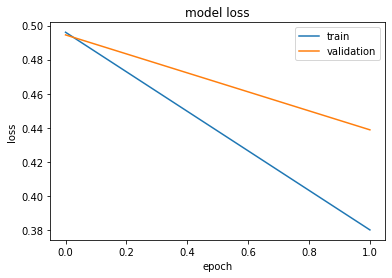

In [ ]:
#Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from tqdm import tqdm
#from data import load_data, tf_dataset
#from train import iou

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = np.expand_dims(x, axis=-1)
    return x

def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [ ]:
with CustomObjectScope({'dice_loss':dice_loss}):
        model = tf.keras.models.load_model("files/model.h5")


In [ ]:

for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
  x = read_image(x)
  y = read_mask(y)
  y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
  h, w, _ = x.shape
  white_line = np.ones((h, 10, 3)) * 255.0

  all_images = [
            x * 255.0, white_line,
            mask_parse(y), white_line,
            mask_parse(y_pred) * 255.0
        ]
  image = np.concatenate(all_images, axis=1)
  cv2.imwrite(f"/content/drive/MyDrive/Kvasir-SEG/results/{i}.jpg", image)

100%|██████████| 100/100 [00:21<00:00,  4.59it/s]
